In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve,auc )
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier, plot_importance

In [ ]:
data=pd.read_csv("data\\PS_20174392719_1491204439457_log.csv")

# EDA

In [4]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [5]:
data['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [6]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [7]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
print(list(data.columns))

# shape of data
print(f'The dataset has shape {data.shape}')

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
The dataset has shape (6362620, 11)


In [10]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


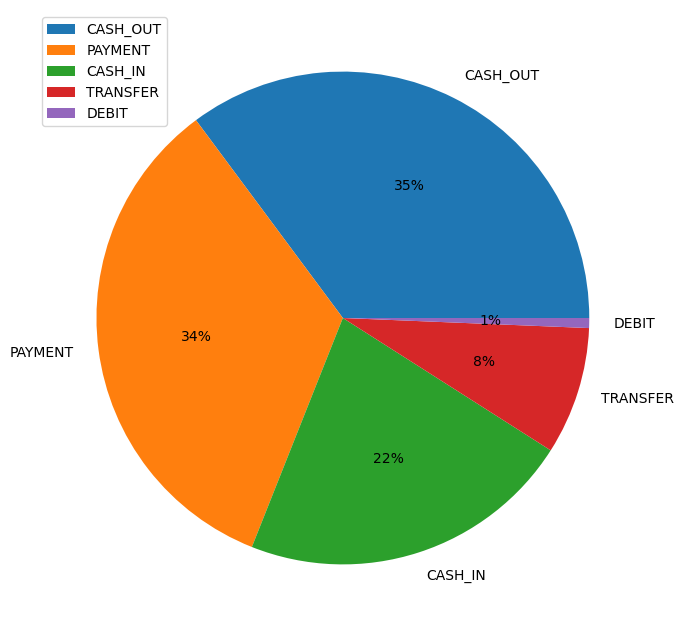

In [13]:
type = data['type'].value_counts()
transaction = type.index
count = type.values

# drawing piechart
plt.figure(figsize=(8,8))
plt.pie(count, labels=transaction, autopct='%1.0f%%')
plt.legend(loc='upper left')
plt.show()

In [14]:
plt.figure(figsize=(12,8))
ax=sns.countplot(x = "type", hue="isFraud", data = data)
plt.title('Types of Transaction nonFraud and Fraud')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

Các loại giao dịch TRANSFER và CASH_OUT chỉ thuộc loại FRAUD (gian lận)

Giao dịch DEBIT rất ít và Giao dịch TRANSFER cũng ít hơn so với các loại giao dịch khác.

In [16]:
data1=data[(data['isFraud']==1) & (data['type']=='TRANSFER')]
data1['nameDest'].value_counts()

nameDest
C553264065     1
C988859148     1
C1287650869    1
C922180689     1
C131895413     1
              ..
C776246900     1
C1234144009    1
C571016162     1
C1381364691    1
C2080388513    1
Name: count, Length: 4097, dtype: int64

In [17]:
data2=data[(data['isFraud']==1) & (data['type']=='CASH_OUT')]
data2['nameOrig'].value_counts()

nameOrig
C840083671     1
C1055498407    1
C1886113938    1
C520336445     1
C463684846     1
              ..
C1641368956    1
C2120940829    1
C992121519     1
C1663597987    1
C1280323807    1
Name: count, Length: 4116, dtype: int64

Không có tài khoản cụ thể nào được sử dụng để thực hiện các giao dịch gian lận -> tên tài khoản không hữu ích 

In [19]:
fraud = data[data["isFraud"] == 1]
valid = data[data["isFraud"] == 0]

In [20]:
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

tạo các feature mới "CC" (Customer to Customer), "CM" (Customer to Merchant), "MC" (Merchant to Customer), "MM" (Merchant to Merchant).

In [22]:
# adding feature type1
data_new = data.copy()
data_new["Type2"] = np.nan 

# filling feature column
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"Type2"] = "CC" 
data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('M'),"Type2"] = "CM"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('C'),"Type2"] = "MC"
data_new.loc[data.nameOrig.str.contains('M') & data.nameDest.str.contains('M'),"Type2"] = "MM"

C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_2440\452184290.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_new.loc[data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'),"Type2"] = "CC"


Số tiền trung vị cho các giao dịch gian lận lớn hơn các giao dịch không gian lận.

Số "Số dư" trong "Tài khoản gốc" trong các giao dịch gian lận trước giao dịch lớn hơn số "Số dư" trong "Tài khoản gốc" của các giao dịch không gian lận.

C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_2440\123492104.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'isFraud', y = 'amount', data = data_new,palette="husl")
C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_2440\123492104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'isFraud', y = 'oldbalanceOrg', data = data_new, palette= 'husl')
C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_2440\123492104.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = data_new,palette="bright")


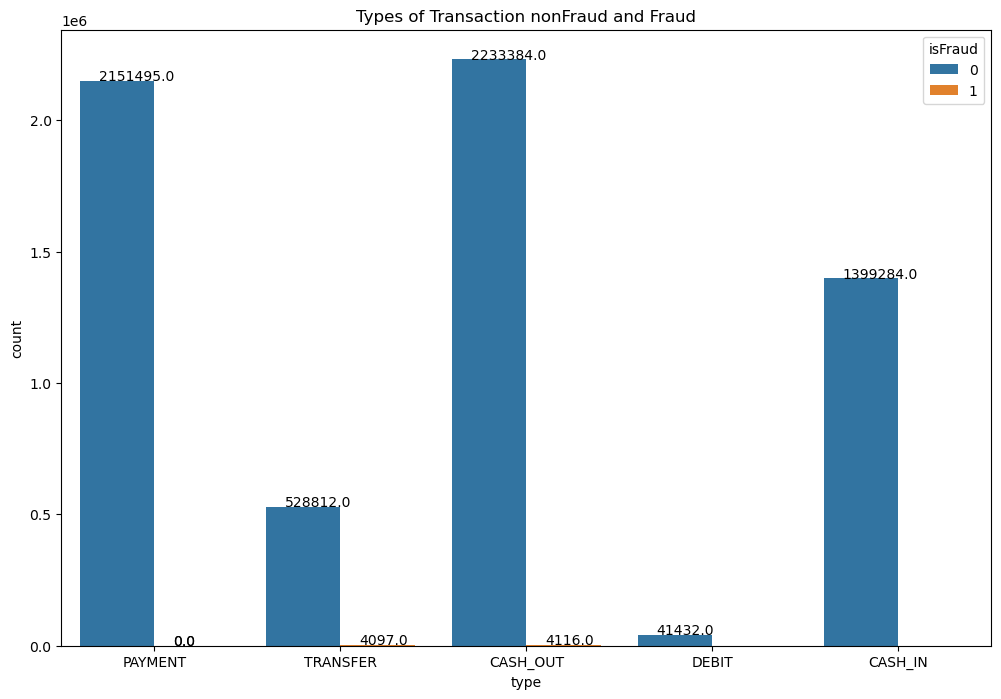

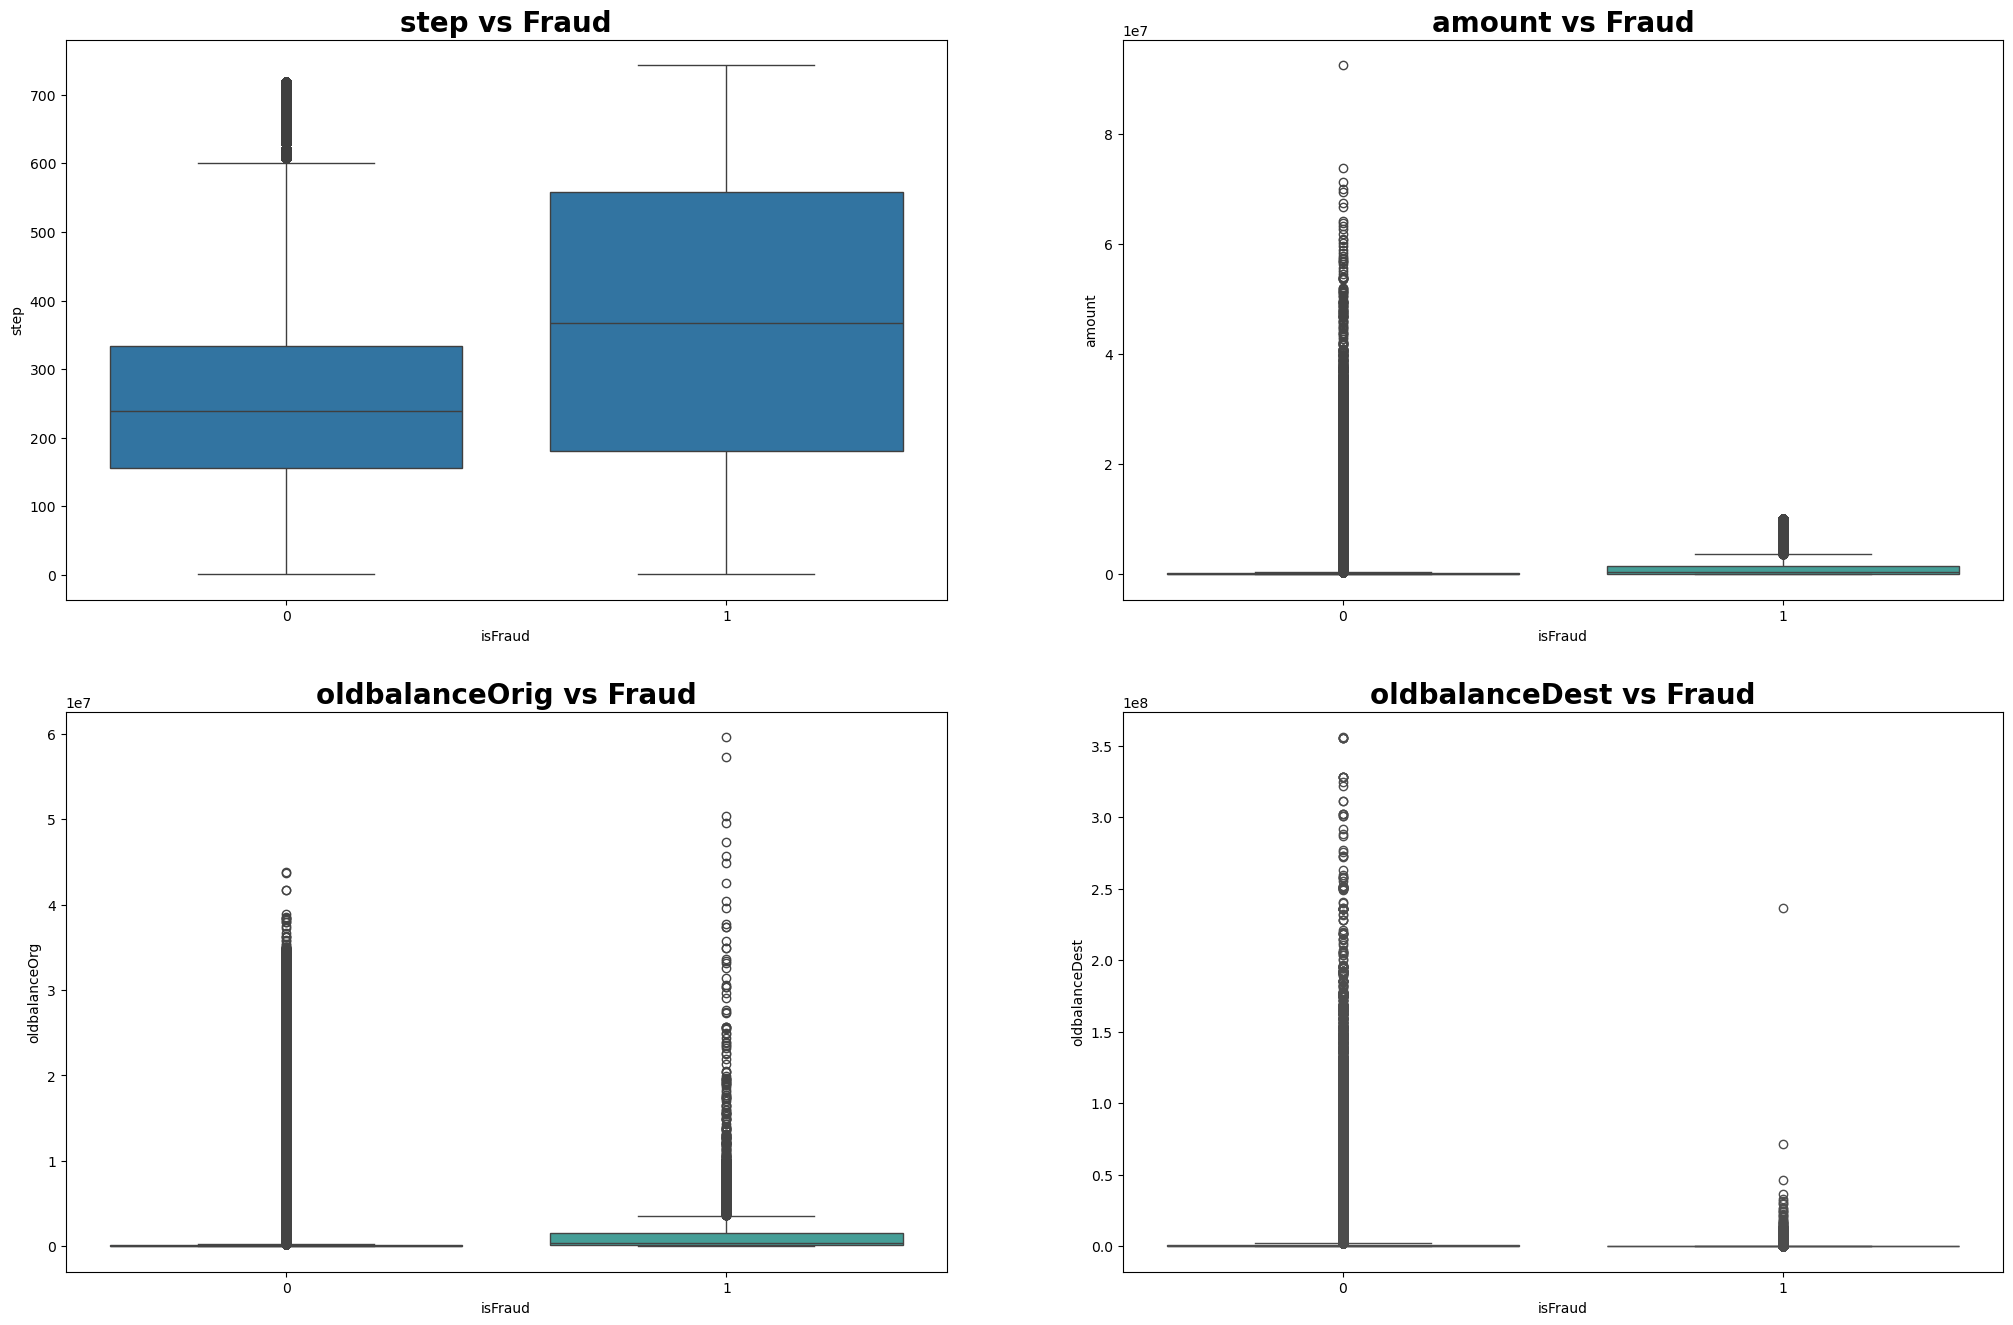

In [24]:
plt.figure(figsize=(25, 16))
plt.subplot(2,2,1)
sns.boxplot(x = 'isFraud', y = 'step', data = data_new)
plt.title('step vs Fraud',fontweight="bold", size=20)
plt.subplot(2,2,2)
sns.boxplot(x = 'isFraud', y = 'amount', data = data_new,palette="husl")
plt.title('amount vs Fraud',fontweight="bold", size=20)
plt.subplot(2,2,3)
sns.boxplot(x = 'isFraud', y = 'oldbalanceOrg', data = data_new, palette= 'husl')
plt.title('oldbalanceOrig vs Fraud',fontweight="bold", size=20)
plt.subplot(2,2,4)
sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = data_new,palette="bright")
plt.title('oldbalanceDest vs Fraud',fontweight="bold", size=20)
plt.show()

In [25]:
fraud = data_new[data_new["isFraud"] == 1]
valid = data_new[data_new["isFraud"] == 0]

In [26]:
print("Fraud transactions by type1: \n",fraud.Type2.value_counts())
print("\n Valid transactions by type1: \n",valid.Type2.value_counts())

Fraud transactions by type1: 
 Type2
CC    8213
Name: count, dtype: int64

 Valid transactions by type1: 
 Type2
CC    4202912
CM    2151495
Name: count, dtype: int64


Từ tập dữ liệu, ta thấy các giao dịch gian lận chỉ xảy ra khi loại giao dịch 1 là CC (Khách hàng với Khách hàng).

In [28]:
wrong_orig_bal = sum(data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"])
wrong_dest_bal = sum(data["newbalanceDest"] + data["amount"] != data["newbalanceDest"])
print("Percentage of observations with balance errors in the account giving money: ", 100*round(wrong_orig_bal/len(data),2))
print("Percentage of observations with balance errors in the account receiving money: ", 100*round(wrong_dest_bal/len(data),2))

Percentage of observations with balance errors in the account giving money:  85.0
Percentage of observations with balance errors in the account receiving money:  100.0


Xem số dư trước và sau giao dịch

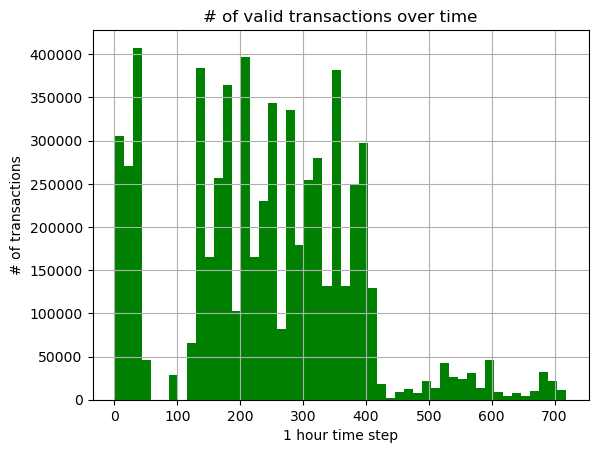

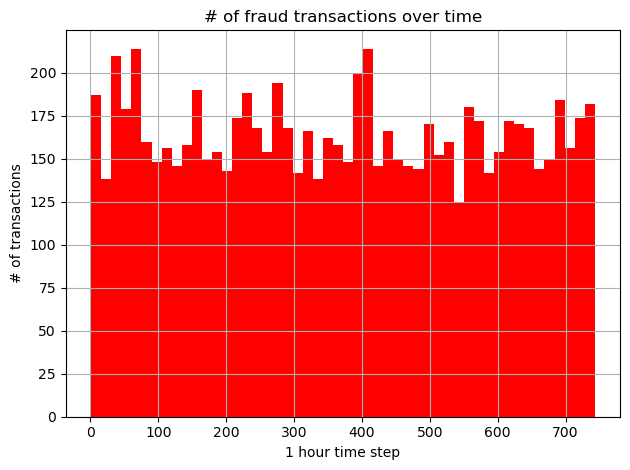

In [30]:
bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

Một tỷ lệ lớn các giao dịch hợp lệ xảy ra giữa khoảng thời gian từ 0 đến 60, cũng như từ 110 đến 410. Tần suất xảy ra các giao dịch gian lận dường như không thay đổi nhiều theo thời gian.

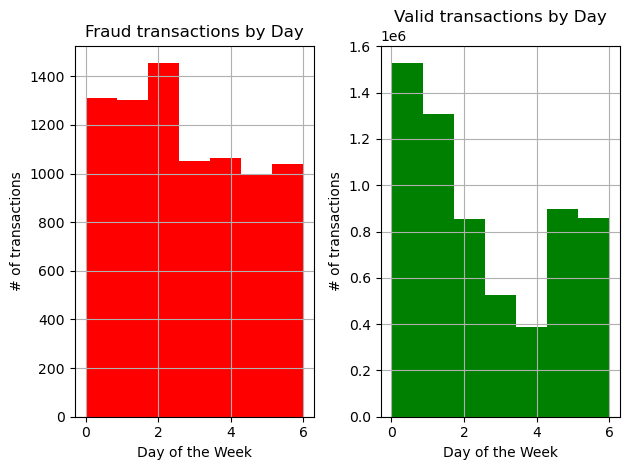

In [32]:
num_days = 7
num_hours = 24
fraud_days = (fraud.step//num_hours)% num_days
fraud_hours = fraud.step % num_hours
valid_days = (valid.step//num_hours) % num_days
valid_hours = valid.step % num_hours

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

ít bằng chứng cho thấy các giao dịch gian lận xảy ra vào những ngày cụ thể trong tuần.

các giao dịch hợp lệ xảy ra ít hơn vào khoảng hai ngày liên tiếp trong tuần.

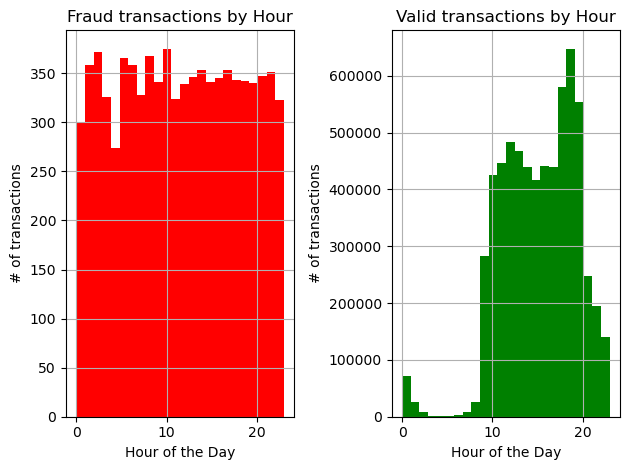

In [34]:
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

từ giờ thứ 0 đến giờ thứ 9, các giao dịch hợp lệ rất hiếm khi xảy ra.

các giao dịch gian lận vẫn xảy ra với tỷ lệ tương tự như bất kỳ giờ nào trong ngày (ngoài giờ thứ 0 đến giờ thứ 9.)

tạo feature HourOfDay 


In [36]:
data_new["HourOfDay"] = np.nan 
data_new.HourOfDay = data_new.step % 24

print("Head of dataset1: \n", pd.DataFrame.head(data_new))

Head of dataset1: 
    step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud Type2  \
0  M1979787155             0.0             0.0        0               0    CM   
1  M2044282225             0.0             0.0        0               0    CM   
2   C553264065             0.0             0.0        1               0    CC   
3    C38997010         21182.0             0.0        1               0    CC   
4  M1230701703             0.0             0.0        0               0    CM   

   HourOfDay  
0          1  
1          1

# Processing

In [48]:
data_new = data_new.drop(["isFlaggedFraud",'nameOrig','nameDest'], axis=1)

In [49]:
data_new = pd.get_dummies(data_new,prefix=['type','Type2'],drop_first=True)

In [50]:
X = data_new.drop("isFraud", axis=1)
y = data_new.isFraud
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
# Normalizing data so that all variables follow the same scale (0 to 1)
scaler = MinMaxScaler()

# Fit only to the training data
X_train=scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Model 

Thực hiện giảm mẫu dữ liệu huấn luyện vì khi sử dụng toàn bộ dữ liệu, tất cả bộ phân loại trừ random forest và neural network phân loại mọi điểm là không gian lận, không phát hiện được giao dịch gian lận. Dữ liệu huấn luyện có hàng triệu bản ghi, nên các mô hình vẫn học tốt với dữ liệu giảm mẫu vì vẫn có đủ số lượng giao dịch.

In [71]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2)

In [73]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2)

In [75]:
X_res, y_res = rus.fit_resample(X_train, y_train)

#### Logistic Regression¶

In [99]:
from sklearn.linear_model import LogisticRegression

In [125]:
clf = LogisticRegression()
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)
y_predtrain = clf.predict(X_train)
CM_LR = confusion_matrix(y_test,y_pred)
CR_LR = classification_report(y_test,y_pred)
CM_LRtrain = confusion_matrix(y_train,y_predtrain)
CR_LRtrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_LR)
print("Classification Report test:\n",CR_LR)
print("Confusion Matrix Train:\n",CM_LRtrain)
print("Classification Report Train:\n",CR_LRtrain)

Accuracy: 0.97602559951718
Confusion Matrix:
 [[1551377   37269]
 [    866    1143]]
Classification Report test:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1588646
           1       0.03      0.57      0.06      2009

    accuracy                           0.98   1590655
   macro avg       0.51      0.77      0.52   1590655
weighted avg       1.00      0.98      0.99   1590655

Confusion Matrix Train:
 [[4653790  111971]
 [   2631    3573]]
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   4765761
           1       0.03      0.58      0.06      6204

    accuracy                           0.98   4771965
   macro avg       0.52      0.78      0.52   4771965
weighted avg       1.00      0.98      0.99   4771965



#### Bernoulli Naive Bayes¶

In [127]:
clf = BernoulliNB()
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)
y_predtrain = clf.predict(X_train)
CM_NB = confusion_matrix(y_test,y_pred)
CR_NB = classification_report(y_test,y_pred)
CM_NBtrain = confusion_matrix(y_train,y_predtrain)
CR_NBtrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_NB)
print("Classification Report test:\n",CR_NB)
print("Confusion Matrix Train:\n",CM_NBtrain)
print("Classification Report Train:\n",CR_NBtrain)

Accuracy: 0.9221371070408102
Confusion Matrix:
 [[1465498  123148]
 [    705    1304]]
Classification Report test:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96   1588646
           1       0.01      0.65      0.02      2009

    accuracy                           0.92   1590655
   macro avg       0.50      0.79      0.49   1590655
weighted avg       1.00      0.92      0.96   1590655

Confusion Matrix Train:
 [[4398248  367513]
 [   2215    3989]]
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96   4765761
           1       0.01      0.64      0.02      6204

    accuracy                           0.92   4771965
   macro avg       0.51      0.78      0.49   4771965
weighted avg       1.00      0.92      0.96   4771965



#### Multinomial Naive Bayes¶

In [130]:
clf = MultinomialNB()
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)
y_predtrain = clf.predict(X_train)
CM_MNB = confusion_matrix(y_test,y_pred)
CR_MNB = classification_report(y_test,y_pred)
CM_MNBtrain = confusion_matrix(y_train,y_predtrain)
CR_MNBtrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_MNB)
print("Classification Report Test:\n",CR_MNB)
print("Confusion Matrix Train:\n",CM_MNBtrain)
print("Classification Report Train:\n",CR_MNBtrain)

Accuracy: 0.916314348491659
Confusion Matrix:
 [[1456558  132088]
 [   1027     982]]
Classification Report Test:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96   1588646
           1       0.01      0.49      0.01      2009

    accuracy                           0.92   1590655
   macro avg       0.50      0.70      0.49   1590655
weighted avg       1.00      0.92      0.96   1590655

Confusion Matrix Train:
 [[4369050  396711]
 [   3090    3114]]
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96   4765761
           1       0.01      0.50      0.02      6204

    accuracy                           0.92   4771965
   macro avg       0.50      0.71      0.49   4771965
weighted avg       1.00      0.92      0.96   4771965



#### Stochastic Gradient Classifier

In [131]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X_res, y_res)
y_pred=clf.predict(X_test)
y_predtrain=clf.predict(X_train)
SGDClassifier(max_iter=5)
CM_svc = confusion_matrix(y_test,y_pred)
CR_svc = classification_report(y_test,y_pred)
CM_svctrain = confusion_matrix(y_train,y_predtrain)
CR_svctrain = classification_report(y_train,y_predtrain)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_svc)
print("Classification Report Test:\n",CR_svc)
print("Confusion Matrix Train:\n",CM_svctrain)
print("Classification Report Train:\n",CR_svctrain)


C:\Users\HO KHOI\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy: 0.9641342717308279
Confusion Matrix:
 [[1532410   56236]
 [    814    1195]]
Classification Report Test:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588646
           1       0.02      0.59      0.04      2009

    accuracy                           0.96   1590655
   macro avg       0.51      0.78      0.51   1590655
weighted avg       1.00      0.96      0.98   1590655

Confusion Matrix Train:
 [[4597067  168694]
 [   2466    3738]]
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   4765761
           1       0.02      0.60      0.04      6204

    accuracy                           0.96   4771965
   macro avg       0.51      0.78      0.51   4771965
weighted avg       1.00      0.96      0.98   4771965



#### RandomForestClassifier

In [138]:
X_res = X_res.astype("float32")

In [140]:
RF = RandomForestClassifier(n_estimators=15,oob_score=True,class_weight='balanced',n_jobs=-1)


RF.fit(X_res, y_res)

y_pred= RF.predict(X_test)
y_predtrain=RF.predict(X_train) 
     
# Evaluating model
CM_RF_train=confusion_matrix(y_train,y_predtrain)
CR_RF_train= classification_report(y_train,y_predtrain)
CM_RF = confusion_matrix(y_test,y_pred)
CR_RF = classification_report(y_test,y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n",CM_RF)
print("Classification Report test:\n",CR_RF)
print("Confusion Matrix Train Data:\n",CM_RF_train)
print("Classification Report Train Data:\n",CR_RF_train)

C:\Users\HO KHOI\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


MemoryError: Unable to allocate 72.8 MiB for an array with shape (4771965, 1, 2) and data type float64

#### Artificial Neural Networks

In [77]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(15, input_shape=(12,), activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

C:\Users\HO KHOI\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)


Epoch 1/5
149124/149124 ━━━━━━━━━━━━━━━━━━━━ 137s 915us/step - accuracy: 0.9990 - loss: 0.0060
Epoch 2/5
149124/149124 ━━━━━━━━━━━━━━━━━━━━ 132s 882us/step - accuracy: 0.9992 - loss: 0.0040
Epoch 3/5
149124/149124 ━━━━━━━━━━━━━━━━━━━━ 134s 898us/step - accuracy: 0.9993 - loss: 0.0040
Epoch 4/5
149124/149124 ━━━━━━━━━━━━━━━━━━━━ 134s 895us/step - accuracy: 0.9993 - loss: 0.0040
Epoch 5/5
149124/149124 ━━━━━━━━━━━━━━━━━━━━ 133s 889us/step - accuracy: 0.9994 - loss: 0.0041


In [80]:
Y_pred1=model.predict(X_test)
Y_pred=np.where(Y_pred1<0.44,0,1)
y_predtrain1=model.predict(X_train)
y_predtrain=np.where(y_predtrain1<0.38 ,0,1)

49708/49708 ━━━━━━━━━━━━━━━━━━━━ 27s 537us/step
149124/149124 ━━━━━━━━━━━━━━━━━━━━ 80s 535us/step


In [81]:
CM_NN = confusion_matrix(y_test,Y_pred)
CR_NN = classification_report(y_test,Y_pred)
CM_NNtrain = confusion_matrix(y_train,y_predtrain)
CR_NNtrain = classification_report(y_train,y_predtrain)
ROC_AUC_SCORENN= roc_auc_score(y_test, Y_pred)
print("Confusion Matrix:\n",CM_NN)
print("Classification Report:\n",CR_NN)
print("Confusion Matrix Train:\n",CM_NNtrain)
print("Classification Report Train:\n",CR_NNtrain)
print("Area Under Curve:",ROC_AUC_SCORENN)

Confusion Matrix:
 [[1588557      28]
 [    951    1119]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588585
           1       0.98      0.54      0.70      2070

    accuracy                           1.00   1590655
   macro avg       0.99      0.77      0.85   1590655
weighted avg       1.00      1.00      1.00   1590655

Confusion Matrix Train:
 [[4765661     161]
 [   2650    3493]]
Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4765822
           1       0.96      0.57      0.71      6143

    accuracy                           1.00   4771965
   macro avg       0.98      0.78      0.86   4771965
weighted avg       1.00      1.00      1.00   4771965

Area Under Curve: 0.7702810421981132
Precision: 0.9755884917175239
Recall: 0.5405797101449276
F1: 0.6956792042275411
